In [129]:
from jaxNRSur.SurrogateModel import NRSur7dq4Model
import jax.numpy as jnp
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

params = jnp.array([1, 0, 0, 0, 0, 0, 0])

model = NRSur7dq4Model()
waveform_jax, dyn_jax = model.get_waveform(jnp.linspace(0, 1, 10), params, theta=0, phi=0) # note the time array here doesn't do anything 

import gwsurrogate

gwsurrogate.catalog.pull('NRSur7dq4')
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

t, h, dyn = sur(1, np.array([0,0,0]), np.array([0,0,0]), dt=1, f_low=0, inclination=0, phi_ref=0, units='dimensionless', precessing_opts={'return_dynamics': True})
#t, h, dyn = sur(1, np.array([0,0,0]), np.array([0,0,0]), dt=1, f_low=0, units='dimensionless', precessing_opts={'return_dynamics': True})

orbphase_gwsur = interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0)(model.data.t_coorb)

Try loading file from cache
Cache found and loading data

NRSur7dq4.h5 file exits, moving to /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup/2024Oct07_14h:14m:22s_NRSur7dq4.h5.
There are a lot of backup files in /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup, consider removing some.
Loaded NRSur7dq4 model


In [130]:
orbphase_gwsur = interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
quat_gwsur = interp1d(t, dyn['q_copr'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi1_gwsur = interp1d(t, dyn['chiA_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi2_gwsur = interp1d(t, dyn['chiB_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)

In [131]:
Omega_interp_gwsur = jnp.hstack([quat_gwsur.T, orbphase_gwsur[:,jnp.newaxis], chi1_gwsur.T, chi2_gwsur.T])

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


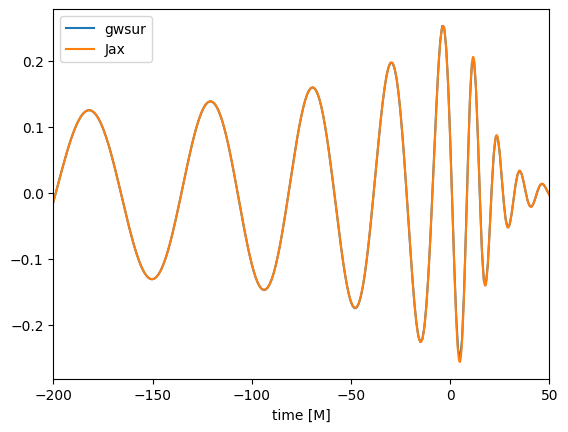

In [132]:
plt.plot(t, h, label='gwsur')
plt.plot(model.data.t_coorb, -waveform_jax*np.exp(2j*(dyn_jax[:,4]-orbphase_gwsur)), label='Jax')

plt.xlabel('time [M]')
plt.legend(loc='upper left')

plt.xlim(-200,50)

plt.show()

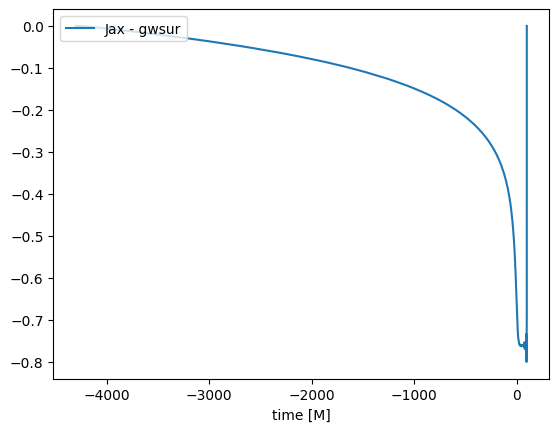

In [133]:
plt.plot(model.data.t_coorb, dyn_jax[:,4]-orbphase_gwsur, label='Jax - gwsur')

plt.xlabel('time [M]')
plt.legend(loc='upper left')

plt.show()

In [134]:
import jax
q=1

# Get the lambda parameters to go into the waveform calculation
lambdas = jax.vmap(model._get_fit_params)(
    jax.vmap(model._get_coorb_params, in_axes=(None, 0))(q, Omega_interp_gwsur)
)

# TODO need to work out how to vmap this later
inertial_h_lms = jnp.zeros((len(model.data.t_coorb), model.n_modes_extended), dtype=complex)

inertial_h_lm_array = {}
coorb_h_lmplus_array = {}
wigner_coefs = {}


for mode in model.modelist_dict.keys():
    # get the coorb hlms
    coorb_h_lm_plus, coorb_h_lm_minus = model.get_coorb_hlm(lambdas, mode=mode)

    coorb_h_lmplus_array[mode] = coorb_h_lm_plus
    

    # Multiply copressing mode by Wigner-D components (N_modes x times)
    # Note that this also does the rotation of the quaternions into the inertial frame
    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], mode).T * coorb_h_lm_plus).T
    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], (mode[0], -mode[1])).T * coorb_h_lm_minus).T

    wigner_coefs[mode] = model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], mode).T

# Sum along the N_modes axis with the spherical harmonics to generate strain as function of time
inertial_h = jnp.zeros(len(model.data.t_coorb), dtype=complex)
for idx in model.modelist_dict_extended.values():
    inertial_h += model.harmonics[idx](0, 0) * inertial_h_lms[:,idx]

    inertial_h_lm_array[list(model.modelist_dict_extended.keys())[idx]] = inertial_h_lms[:,idx]

(-200.0, 50.0)

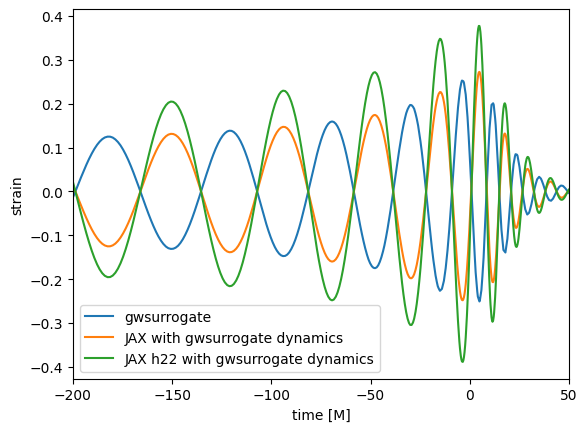

In [135]:
plt.plot(model.data.t_coorb, interp1d(t,h, bounds_error=False, fill_value=0, kind='linear')(model.data.t_coorb), label='gwsurrogate')
plt.plot(model.data.t_coorb, inertial_h, label='JAX with gwsurrogate dynamics')
plt.plot(model.data.t_coorb, inertial_h_lm_array[(2,2)], label='JAX h22 with gwsurrogate dynamics') #(-2.22919481+0.00253773j)*
plt.legend()
plt.xlabel('time [M]')
plt.ylabel('strain')
plt.xlim(-200, 50)

/tmp/ipykernel_25800/1482465551.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(-200.0, 50.0)

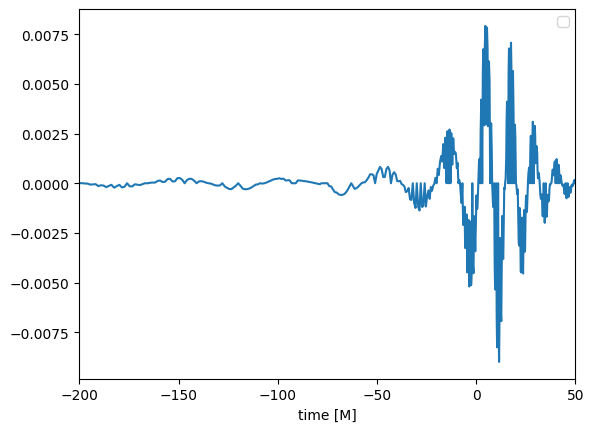

In [128]:
plt.plot(model.data.t_coorb, inertial_h_lm_array[(2,2)]-interp1d(t,h[(2,2)], bounds_error=False, fill_value=0, kind='linear')(model.data.t_coorb)) #(-2.22919481+0.00253773j)*
plt.legend()
plt.xlabel('time [M]')
plt.xlim(-200, 50)